In [1]:
import dgl
import dgl.function as fn
import torch.nn.functional as F
from dgl import DGLGraph
import time
from dgl.data import citation_graph as citegrh
from scipy import sparse
from sklearn import preprocessing 
from tqdm import tqdm
import networkx as nx
import geopandas as gpd
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import math
import random
import community
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from modularity_maximization import partition
device = torch.device('cpu')

Using backend: pytorch


In [2]:
sample_num = 2000

### Graph Construction —— Population Flow

In [3]:
# 确认节点数量
bs_gpd = gpd.read_file('../../data/basestation-gis/basestation_aggregation.shp')
bs_gpd = bs_gpd.iloc[:sample_num:, ::]
bs_num = bs_gpd.shape[0]

# 构造图节点
nodes_list = list(range(bs_num))
G = nx.Graph()
G.add_nodes_from(nodes_list)

# 读取邻接矩阵adjacent
# 以工作日(周一)的早高峰时段为例
adj = pd.read_csv('../../data/adj/adj_20151109_0002.csv')
adj = adj.iloc[:, 1:].values
adj = adj[:sample_num:, :sample_num:]
adj = adj + adj.T
for i in range(sample_num): adj[i, i] = 0
    
# for i in range(bs_num):
#     if (adj[i]==0).all():
#         adj[i, :] = 0.0001
#         adj[:, i] = 0.0001

# D_12 = np.diag(np.power(np.sum(adj, axis=0)+0.00001, -1/2))
# adj_norm = np.dot(np.dot(D_12, adj), D_12)

for i in tqdm(range(bs_num)):
    for j in range(bs_num):
        tmp = adj[i, j]
        if tmp>0: G.add_edge(i, j, weight=tmp)

100%|██████████| 2000/2000 [00:03<00:00, 589.32it/s]


### Graph Construction —— Geographic Reachability

### Feature Construction —— Equality Contribution

In [4]:
feature = pd.read_csv('../../data/features/features_wf_new.csv')
feature = feature.iloc[:, 1::].values

In [5]:
feature = feature[:sample_num:, :]

### Prior Information

In [8]:
partition = community.best_partition(G)
partition_count = {}
for key, value in partition.items():
    if value not in partition_count:
        partition_count[value] = 1
    else:
        partition_count[value] = partition_count[value] + 1

In [9]:
print(community.modularity(partition, G, weight='weight'))
clusters_number = 0
for key, value in partition_count.items():
    if value > 1:
        clusters_number = clusters_number + 1
print(clusters_number)
remapping = {}
idx = 0
for key, value in partition_count.items():
    if value>1 and key not in remapping:
        remapping[key] = idx
        idx = idx + 1

alpha = 0.01
W_prior = np.zeros((bs_num, clusters_number))
for key, value in partition.items():
    try:
        W_prior[key, remapping[value]] = alpha
    except:
        pass

0.6028645604090356
11


### Net Initial 

np.identity()只能创建方阵，np.eye()可以创建一般矩阵，主对角线为1，其余元素为0。

In [10]:
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

A = torch.from_numpy(adj).float()
d = torch.from_numpy(np.sum(adj, axis=1).reshape((-1, 1))).float()
mm = np.sum(adj)
B = A - torch.mm(d, d.T)/mm
B_norm = B/mm
DG1 = dgl.DGLGraph()
DG1.from_networkx(G)
features = torch.from_numpy(feature).float()

# D_ = th.diag(th.pow(d.view(-1), -1/2))
# A_norm = th.mm(th.mm(D_, A), D_)

# k = 15
in_dim = features.size()[1]
out_dim = clusters_number

In [11]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

In [12]:
class GCN_model(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCN_model, self).__init__()
        self.layer = GCNLayer(in_feats, out_feats)
        # self.B = B

    def forward(self, g, features, beta):
        global gcn_output
        n = nn.Softmax(dim=1)
        
        gcn_output = self.layer(g, features)
        weight_feature = n(gcn_output)
        W_noise = torch.div(torch.exp(weight_feature)-1, torch.exp(weight_feature)+1)*beta
        return W_noise

In [22]:
# clusters_number = 15
A_hat = torch.tensor(nx.adjacency_matrix(G).todense(), dtype=np.float) # a matrix: A
X = np.identity(G.number_of_nodes(), dtype=np.float)

class OURS(nn.Module):
    def __init__(self, B_norm, num_feat, num_hidden):
        super(OURS, self).__init__()
        self.num_feat = num_feat # 特征数 f
        self.num_hidden = num_hidden # 隐含数 h
        self.B_norm = B_norm.float()
        self.W_0 = nn.Parameter(torch.ones(num_feat, num_hidden)+W_prior) # [1][f*h]

    def forward(self, X, A_hat,temp, epoch, W_noise): # X貌似暂时没有用到
        global featureSelector # 
        global weight_feature # 
        # f = nn.Softmax(dim=1)
        featureSelector = self.W_0 + W_noise # [1][f*h]
        results = torch.zeros(self.W_0.size()) # [0][f*h]
        x = 2*(epoch+1) # x次取平均,目测这个目的是为了稳定。
        for i in range(x):
            # logits --> self.W_0: [batch_size, num_features] 非规范化对数概率
            # tau: 非负的对抗强度。
            # hard: 如果 True, 返回的样本将会离散为 one-hot 向量
            results += F.gumbel_softmax(featureSelector,tau=temp,hard=False)
        weight_feature = results/x # [-][f*h]

        # H = torch.mm(torch.mm(weight_feature.T, B), weight_feature) # weight_feature 就是我们要求的U
        H = torch.mm(torch.mm(weight_feature.T, self.B_norm), weight_feature) # weight_feature 就是我们要求的U
        Hh = torch.div(H, H.sum(axis=0)) # 按照每一列进行归一化，列为axis=0的方向。
        m = nn.Softmax(dim=0)
        return m(Hh)
    
def lossFn(output): 
    return torch.trace(-torch.log(output))

### Partition Process

<font color='red'>Experiment Set: $\alpha = 0.01$</font>

In [43]:
num_feat = len(G.nodes()) # f = 节点数
num_hidden = clusters_number # h = 聚类数

model_base = OURS(A_hat, num_feat, num_hidden).to(device)
model_gcn = GCN_model(in_dim, out_dim)

optimizer_base = optim.Adam(model_base.parameters(),lr=1.5e-2)
optimizer_gcn = torch.optim.Adam(model_gcn.parameters(), lr=1e-2)
# optimizer = optim.Adam(model.parameters(),lr=1e-2,weight_decay=0,betas=(0.5, 0.999), eps=1e-08)

A_hat_tensor = torch.Tensor(A_hat.float()).to(device)
X_tensor = torch.Tensor(X).to(device)

loss_hist = []
modularity_hist = []
# acc_hist = []
temp = 3
beta = 0

for epoch in range(500):
    model_base.train()
    model_base.zero_grad()
    model_gcn.train()
    model_gcn.zero_grad()
    if(epoch == 75):
        temp = 2.75
    elif(epoch == 100):
        temp = 2.5
    elif(epoch == 125):
        temp = 2
    elif(epoch == 150):
        temp = 1.8
    elif(epoch == 175):
        temp = 1.25
    elif(epoch == 250):
        temp = 1.00
    elif(epoch == 300):
        temp = 0.75
    elif(epoch == 320):
        temp = 0.50
    elif(epoch == 400):
        temp = 0.20
    W_noise = model_gcn(DG1, features, beta)
    output = model_base(X_tensor, A_hat_tensor, temp, epoch, W_noise)
    ############################################
    loss = lossFn(output)
    loss_hist.append(loss.item())
    ############################################
    gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
    labels_pred = gumbel_matrix.data.numpy()
    modularity = community.modularity(dict(zip(list(range(len(labels_pred))), labels_pred)), G, weight='weight')
    modularity_hist.append(modularity)
    
    if epoch%10==0: 
        print('Epoch: ', epoch, '; Loss: ', round(loss.item(), 4), '; Modulariy: ', round(modularity, 4))
    loss.backward()
    optimizer_base.step()
    optimizer_gcn.step()

Epoch:  0 ; Loss:  26.3765 ; Modulariy:  0.003
Epoch:  10 ; Loss:  26.3767 ; Modulariy:  -0.0005
Epoch:  20 ; Loss:  26.3764 ; Modulariy:  0.0044
Epoch:  30 ; Loss:  26.3754 ; Modulariy:  0.0266
Epoch:  40 ; Loss:  26.3728 ; Modulariy:  0.1307
Epoch:  50 ; Loss:  26.367 ; Modulariy:  0.1632
Epoch:  60 ; Loss:  26.3559 ; Modulariy:  0.2186
Epoch:  70 ; Loss:  26.3381 ; Modulariy:  0.2188
Epoch:  80 ; Loss:  26.3003 ; Modulariy:  0.236
Epoch:  90 ; Loss:  26.2564 ; Modulariy:  0.2687
Epoch:  100 ; Loss:  26.1739 ; Modulariy:  0.239
Epoch:  110 ; Loss:  26.0984 ; Modulariy:  0.2645
Epoch:  120 ; Loss:  26.0127 ; Modulariy:  0.264
Epoch:  130 ; Loss:  25.7538 ; Modulariy:  0.3272
Epoch:  140 ; Loss:  25.6186 ; Modulariy:  0.3105
Epoch:  150 ; Loss:  25.3712 ; Modulariy:  0.3642
Epoch:  160 ; Loss:  25.2003 ; Modulariy:  0.3903
Epoch:  170 ; Loss:  25.0102 ; Modulariy:  0.4317
Epoch:  180 ; Loss:  24.3602 ; Modulariy:  0.4475
Epoch:  190 ; Loss:  24.0072 ; Modulariy:  0.4752
Epoch:  200 ; L

**GCN noise $\beta = 5$**

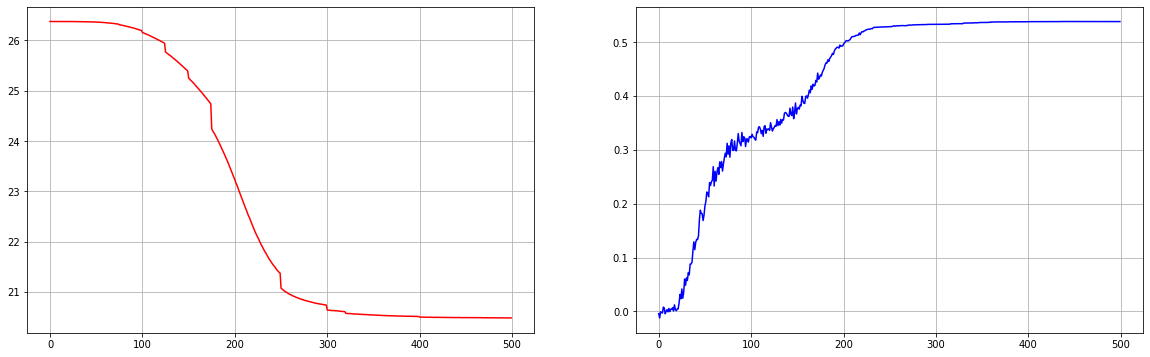

torch.Size([2000, 11])


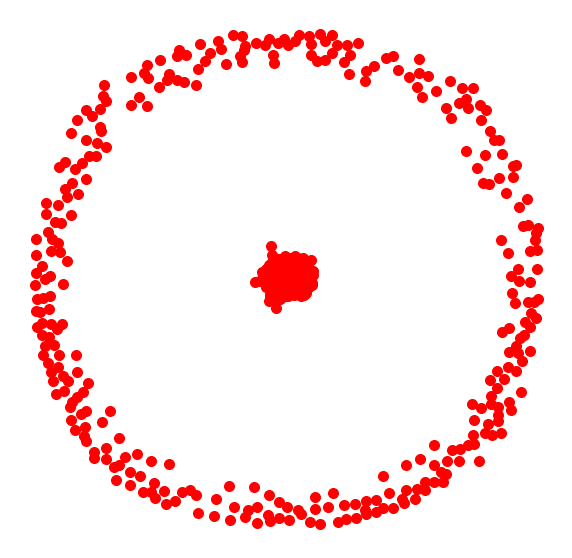

0.537994755832285


In [32]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(modularity_hist, color='blue')
plt.grid(True)
plt.show()

print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=100, node_color="r", with_labels=False)
options = {
    'node_color': 'red',
    'node_size': 10,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print(max(modularity_hist))

**GCN noise $\beta = 1.0$**

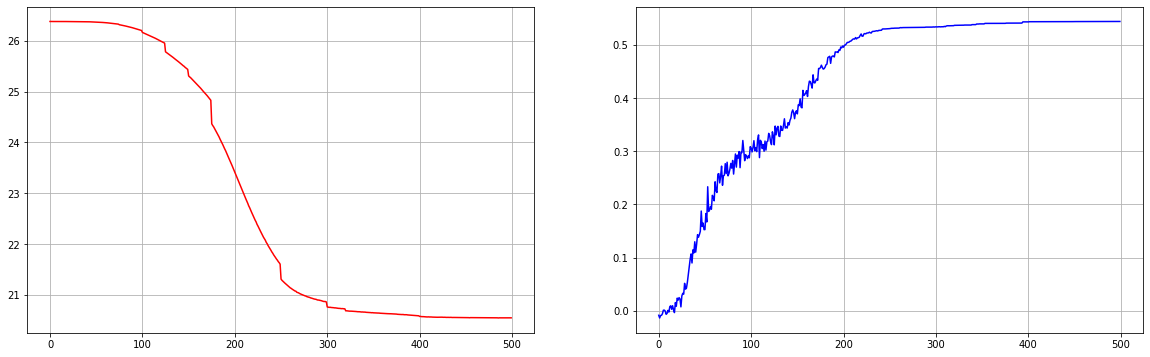

torch.Size([2000, 11])


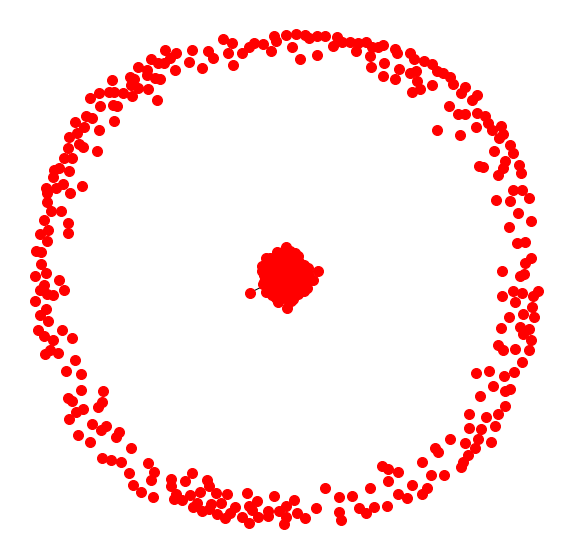

0.5438839333941085


In [30]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(modularity_hist, color='blue')
plt.grid(True)
plt.show()

print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=100, node_color="r", with_labels=False)
options = {
    'node_color': 'red',
    'node_size': 10,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print(max(modularity_hist))

**GCN noise $\beta = 0.5$**

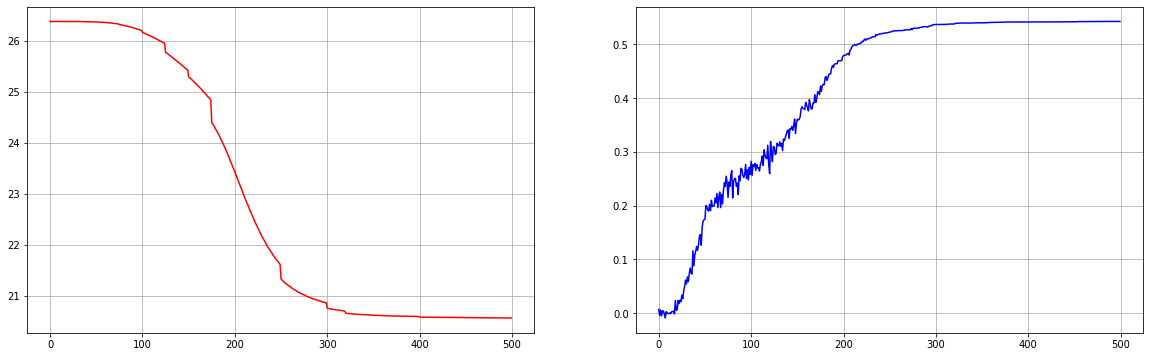

torch.Size([2000, 11])


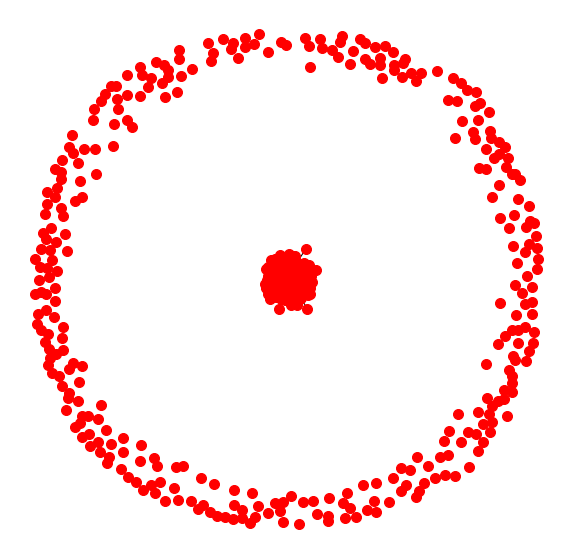

0.5423487336824188


In [28]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(modularity_hist, color='blue')
plt.grid(True)
plt.show()

print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=100, node_color="r", with_labels=False)
options = {
    'node_color': 'red',
    'node_size': 10,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print(max(modularity_hist))

**GCN noise $\beta=0.1$**

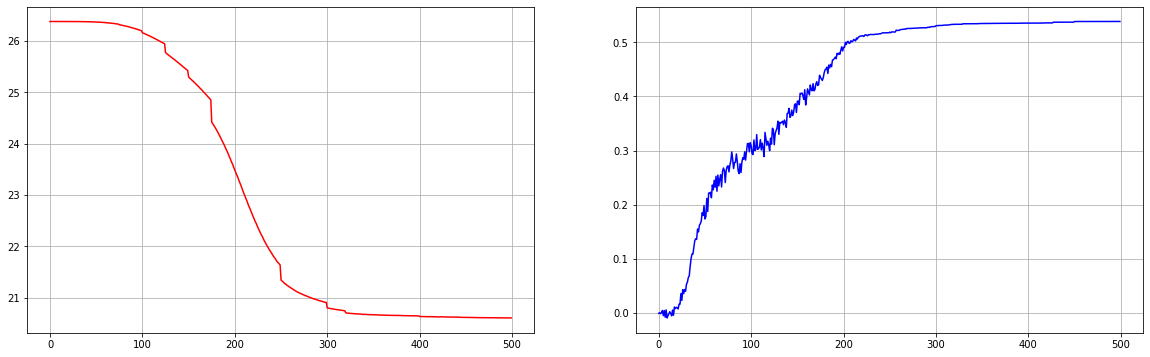

torch.Size([2000, 11])


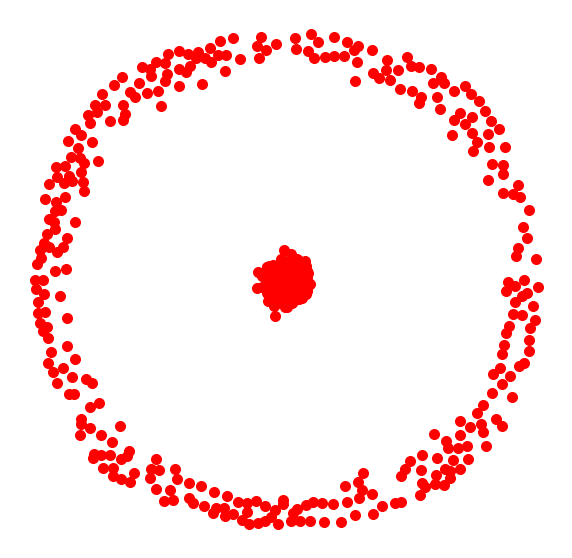

0.5386163854349485


In [24]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(modularity_hist, color='blue')
plt.grid(True)
plt.show()

print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=100, node_color="r", with_labels=False)
options = {
    'node_color': 'red',
    'node_size': 10,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print(max(modularity_hist))

**GCN noise $\beta=0.0$**

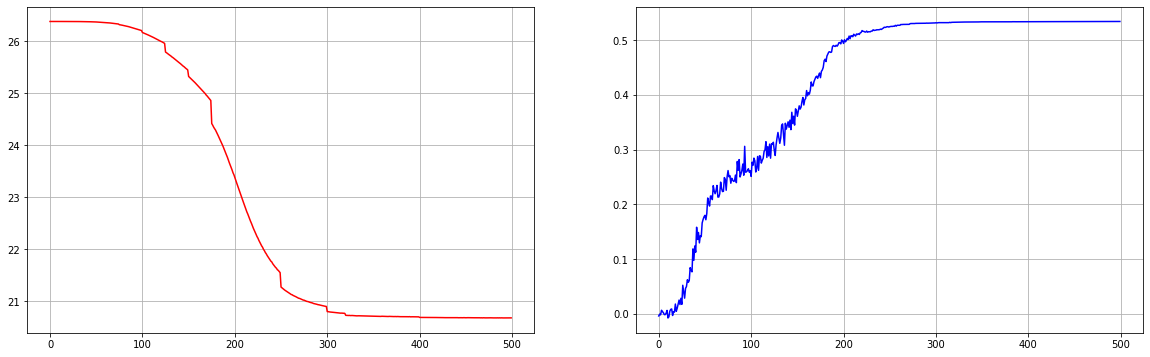

torch.Size([2000, 11])


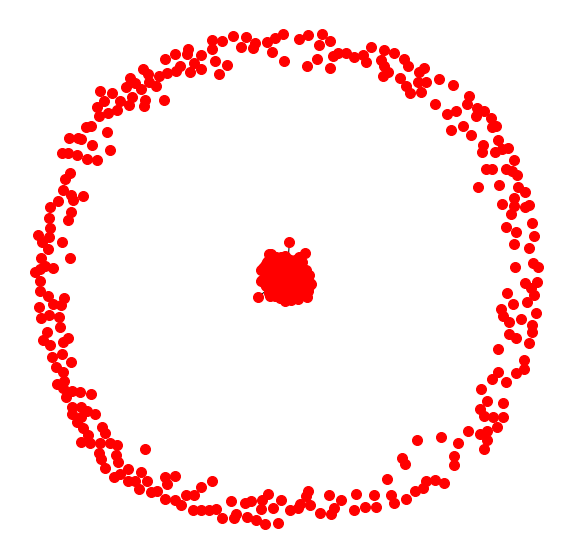

0.5340508332559488


In [26]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(modularity_hist, color='blue')
plt.grid(True)
plt.show()

print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=100, node_color="r", with_labels=False)
options = {
    'node_color': 'red',
    'node_size': 10,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print(max(modularity_hist))